In [2]:
import pandas as pd
import numpy as np
import os

from nltk.corpus import stopwords 
from nltk.corpus import wordnet 
from nltk import wordpunct_tokenize
from nltk import WordNetLemmatizer
from nltk import sent_tokenize
from nltk import pos_tag

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import BernoulliNB, MultinomialNB, GaussianNB

from imblearn.pipeline import make_pipeline


In [3]:
# Data source: https://raw.githubusercontent.com/cestella/NLPDemo/solution/NLPDemo/src/main/data/sentences.dat
df = pd.read_csv('../icd_codes.csv', names = ["ICD_9", "Type", "sentences"])
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3829 entries, 0 to 3828
Data columns (total 3 columns):
ICD_9        3829 non-null object
Type         3829 non-null object
sentences    3829 non-null object
dtypes: object(3)
memory usage: 89.8+ KB


In [4]:
df.nunique()

ICD_9          45
Type            2
sentences    2871
dtype: int64

In [5]:
# remove icd code whose count is less than 10 times
c = df['ICD_9'].value_counts()
a = ['462', '791', '596.8', '593.1','785.6','783','753','79.99','786.59' 
     ,'758.6','V42.0','788.41','V72.5','511.9','279.12']

df = df[~df['ICD_9'].isin(a)]
df

,ICD_9,Type,sentences
4,277,CLINICAL_HISTORY,1 year old with ...
5,277,CLINICAL_HISTORY,12-year - old ma...
6,277,CLINICAL_HISTORY,16 month old wit...
7,277,CLINICAL_HISTORY,16-year 6-month ...
8,277,CLINICAL_HISTORY,17-year - old wi...
9,277,CLINICAL_HISTORY,18-year - old wi...
10,277,CLINICAL_HISTORY,4-year - old wit...
11,277,CLINICAL_HISTORY,Approximately 19...
12,277,CLINICAL_HISTORY,CF. Yearly evalu...
13,277,CLINICAL_HISTORY,Cystic Fibrosis.


In [7]:
# ## Create a dictionary of customerID,description pairs
token_dict = pd.Series(df['sentences'].values,index=df['ICD_9']).to_dict()
token_dict

{'277': "Very mild peribronchial cuffing consistent with patient's known history of cystic fibrosis. This is not significantly changed allowing for better aeration on today's exam when compared with the exam from 1/2/01.",
 '486': 'Worsening airspace disease as described.',
 '493.9': 'Viral vs reactive airway disease.',
 '518': 'Subsegmental atelectasis in the left lower lobe, otherwise normal exam.',
 '591': 'Worsening of the hydronephrosis of the left upper pole moiety and new hydronephrosis in the left lower pole moiety. This could represent effects of obstructing postoperative edema.',
 '592': 'Unchanged right renal nonobstructing calculi.',
 '593.5': 'Stable moderately severe left - sided hydronephrosis and hydroureter.',
 '593.7': 'The right kidney does not appear to have grown. There is no hydronephrosis or hydroureter. Intrinsically, the kidneys appear normal. However, failure of growth of the kidney may reflect the patient has recurrent infections, scarring or reflux.',
 '593.

In [8]:
# Use line below for just unigrams
v = TfidfVectorizer()

# Use line below for unigrams, bigrams, and trigrams
#v = TfidfVectorizer(ngram_range=(2,3))  



X = v.fit_transform(df['sentences']).toarray()

convoDF = pd.DataFrame() # Initialize new DF

for i, col in enumerate(v.get_feature_names()):
    convoDF[col] = X[:, i]

In [9]:
convoDF.head()

,00,01,04,05,09,0cm,10,100,101,102,...,x3,x4,x5,xray,year,yearly,years,yesterday,zithromax,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.179822,0.000000,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.180348,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.140886,0.364569,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.237390,0.000000,0.0,0.0,0.0,0.0


In [10]:
Y = df['ICD_9']

In [11]:
c=convoDF.values

In [12]:
scaler = StandardScaler()
scaler.fit(convoDF)
x_s = scaler.transform(convoDF)
x_s

#Y.head()

StandardScaler(copy=True, with_mean=True, with_std=True)

array([[-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       ..., 
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416]])

In [65]:
# save scaler so it can be used on new data to transform it the same way it did on the training set
import pickle
scalerfile = 'scaler.sav'
pickle.dump(scaler, open(scalerfile, 'wb'))

In [17]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(x_s, Y, test_size=0.2, random_state=42)
X_train
y_train[:5]

array([[-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       ..., 
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416],
       [-0.01632993, -0.129769  , -0.02309709, ..., -0.03448159,
        -0.01632993, -0.03081416]])

2283    780.6
506       591
2222    780.6
3356    786.2
1806    599.7
Name: ICD_9, dtype: object

# SVM


In [37]:
#http://scikit-learn.org/0.18/auto_examples/model_selection/grid_search_digits.html
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.svm import SVC

tuned_parameters = [{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]#,
                    #{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                    #                       'C': [1, 10, 100, 1000]},
                    #{'kernel': ['sigmoid'],'gamma': [1e-3, 1e-4],
                    #                       'C': [1, 10, 100, 1000]}]

svc = svm.SVC()
clf = GridSearchCV(svc, tuned_parameters, cv=5)#,
                       #scoring='%s_macro' % score)
clf.fit(X_train, y_train)

print("Best parameters set found on development set:")
print()
print(clf.best_params_)

GridSearchCV(cv=5, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Best parameters set found on development set:

{'C': 1, 'kernel': 'linear'}


In [38]:
print(clf.best_score_)

0.342


In [15]:
from sklearn import svm
# Create SVM classification object 
model = svm.SVC(kernel='linear', C=1)#, gamma='auto') 
# there is various option associated with it, like changing kernel, gamma and C value. Will discuss more # about it in next section.Train the model using the training sets and check score
model.fit(X_train, y_train)
model.score(X_test, y_test)
#Predict Output
#predicted= model.predict(X_test)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

0.34886817576564583

In [61]:
model.predict(X_test)

array(['486', '599', '786.5', '591', '599', '596.54', '786.07', '591',
       '795.5', '591', '486', '780.6', '591', '593.89', '753.21', '593.89',
       '596.54', '786.2', '493.9', '599', '599', '786.5', '591', '780.6',
       '486', '786.2', '599', '596.54', '486', '599', '486', '593.7',
       '780.6', '795.5', '599', '486', '786.2', '789', '591', '786.2',
       '786.2', '486', '593.7', '780.6', '593.89', '780.6', '788.3',
       '599.7', '591', '786.2', '593.7', '780.6', '593.7', '493.9', '599',
       '786.2', '780.6', '786.07', '786.5', '593.89', '780.6', '518',
       '753.3', '486', '786.2', '753.3', '593.7', '593.89', '486', '593.7',
       '786.5', '486', '277', '591', '786.2', '486', '780.6', '599', '518',
       '786.2', '493.9', '786.2', '591', '593.5', '786.2', '786.5',
       '786.2', '599', '788.3', '591', '596.54', '788.3', '780.6', '592',
       '599', '780.6', '277', '591', '486', '780.6', '493.9', '780.6',
       '780.6', '786.07', '786.2', '593.7', '786.2', '780.6

In [ ]:
# pickled svm model
import pickle
#conda install requests will be needed
import requests, json
pickle.dump(model, open("icd9_svm.pkl", "wb"))

In [20]:
# load back pickled file 
my_svm = pickle.load(open("icd9_svm.pkl", "rb"))

In [21]:
my_svm

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [23]:
from sklearn.metrics import accuracy_score

print("Accuracy = %0.2f" % accuracy_score (y_test, my_svm.predict(X_test)))
#print(classification_report(y_test, my_svm.predict(X_test)))

Accuracy = 0.35


# connect web service by ICD9_svm.py (api)

In [15]:
import sys
import json
import requests

url = "http://localhost:9000/api"
data = json.dumps({'sentences':'male with wheezing.'}) 
r = requests.post(url, data)

print(r.json())
# actual code: 518
# model still needs some improvment 

{'results': {'ICD9 code': '786.07'}}


# Compare Algorithms
#https://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/


KNN: 0.348333 (0.023863)
CART: 0.356667 (0.034512)
NB: 0.166667 (0.019322)
SVM: 0.390333 (0.014791)


Text(0.5,0.98,'Algorithm Comparison')

{'boxes': [<matplotlib.lines.Line2D at 0x1a16c9c400>,
 'caps': [<matplotlib.lines.Line2D at 0x1a16c9ce10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1a16cb4ac8>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x1a16cb46a0>,
 'whiskers': [<matplotlib.lines.Line2D at 0x1a16c9c550>,
  <matplotlib.lines.Line2D at 0x1a168db518>]}

[Text(0,0,'KNN'), Text(0,0,'CART'), Text(0,0,'NB'), Text(0,0,'SVM')]

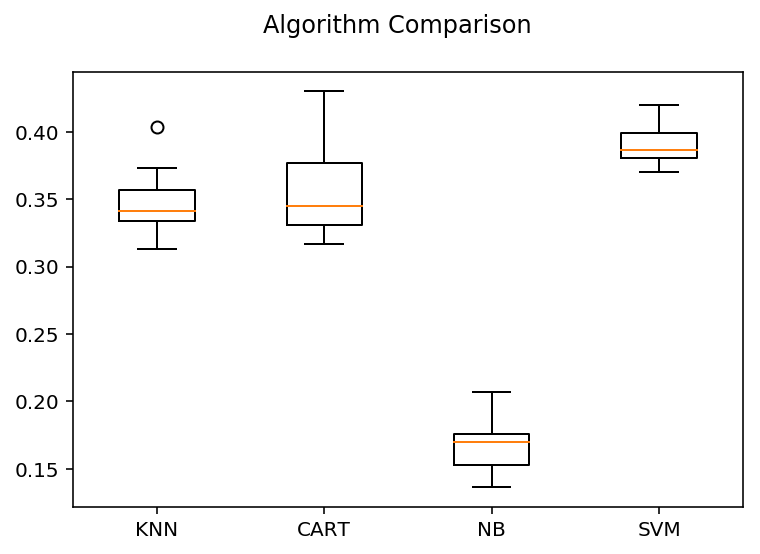

In [20]:
import pandas
import matplotlib.pyplot as plt
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

# prepare configuration for cross validation test harness
seed = 7
# prepare models
models = []
#models.append(('LR', LogisticRegression()))
#models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'
for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)
# boxplot algorithm comparison
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()